W0813 05:50:21.779605 139625899067264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


11493376/11490434 [==============================] - 0s 0us/step
Epochs: 20000
Batch size: 128
----------- Epoch 1 -----------
1 [D loss: 0.936675, acc.: 42.58%] [G loss: 0.540486]


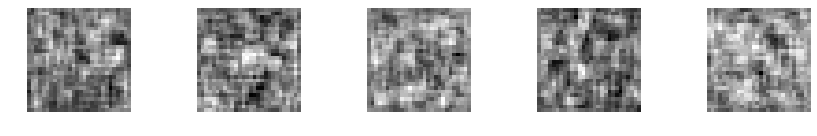

----------- Epoch 5000 -----------
5000 [D loss: 0.064958, acc.: 98.44%] [G loss: 4.511599]


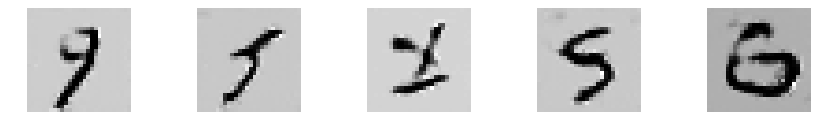

----------- Epoch 10000 -----------
10000 [D loss: 0.018658, acc.: 100.00%] [G loss: 11.601451]


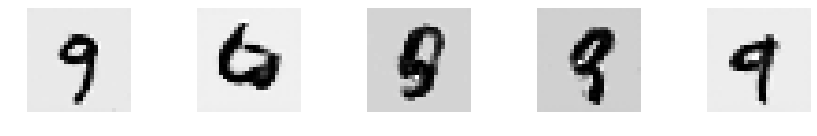

----------- Epoch 15000 -----------
15000 [D loss: 0.029231, acc.: 100.00%] [G loss: 9.360611]


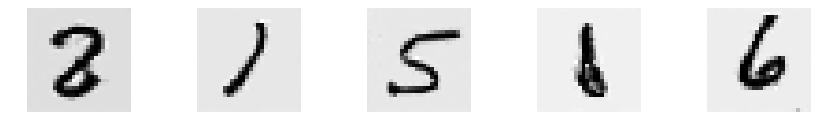

----------- Epoch 20000 -----------
20000 [D loss: 0.037703, acc.: 100.00%] [G loss: 4.470615]


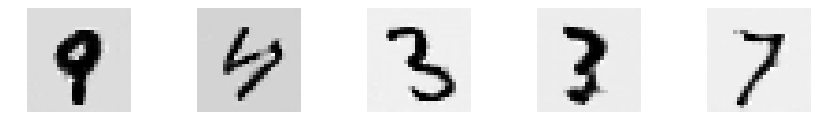

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, UpSampling2D, Flatten, Reshape, ZeroPadding2D


class DCGAN(object):
    def __init__(self):
        self.z_dim = 100
        self.width = 28
        self.height = 28
        self.channels = 1
        self.img_shape = (self.width, self.height, self.channels)
        self.adam = Adam(lr=0.0002, beta_1=0.5)
        
        self.generator = self.Build_Generator()
        
        self.discriminator = self.Build_Discriminator()
        self.discriminator.compile(loss = 'binary_crossentropy', optimizer = self.adam, metrics = ['accuracy'])
        self.discriminator.trainable = False
        
        inputs = Input(shape = (self.z_dim,))
        hidden = self.generator(inputs)
        output = self.discriminator(hidden)
        self.combined = keras.Model(inputs, output)
        self.combined.compile(loss = 'binary_crossentropy', optimizer = self.adam)
        
        
    def Build_Generator(self):
        model = keras.Sequential(
        [
            Dense(128 * 7 * 7, activation = 'relu', input_dim = self.z_dim),
            Reshape((7, 7, 128)),
            UpSampling2D(),
            Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu'),
            BatchNormalization(),
            UpSampling2D(),
            Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu'),
            BatchNormalization(),
            Conv2D(1, kernel_size = 3, padding = 'same', activation = 'tanh')
        ])
        
        return model
    
    
    def Build_Discriminator(self):
        model = keras.Sequential(
        [
            Conv2D(32, kernel_size = 3, strides = 2, input_shape = self.img_shape, padding = 'same'),
            LeakyReLU(alpha = 0.2),
            Conv2D(64, kernel_size = 3, strides = 2, padding = 'same'),
            BatchNormalization(momentum = 0.8),
            LeakyReLU(alpha = 0.2),
            Conv2D(128, kernel_size = 3, strides = 2, padding = 'same'),
            BatchNormalization(momentum = 0.8),
            LeakyReLU(alpha = 0.2),
            Conv2D(256, kernel_size = 3, strides = 1, padding = 'same'),
            BatchNormalization(momentum = 0.8),
            LeakyReLU(alpha = 0.2),
            Flatten(),
            Dense(1, activation = 'sigmoid')
        ])
        
        return model
    
    def Plot_Generated(self, n_ex = 5, dim = (1, 5), figsize = (12, 2)):
        noise = np.random.normal(0, 1, size = (n_ex, self.z_dim))
        generated_images = self.generator.predict(noise)
        generated_images = generated_images.reshape(generated_images.shape[0], self.width, self.height)
        plt.figure(figsize = figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(generated_images[i, :, :], interpolation = 'nearest', cmap = 'gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        
    def Train(self, epochs = 20000, plt_frq = 5000, batch_size = 128):
        (train_x, _), (_, _) = keras.datasets.mnist.load_data()

        train_x = train_x.reshape(60000, self.width, self.height, self.channels)
        train_x = train_x.astype('float32')/255
        
        print('Epochs:', epochs)
        print('Batch size:', batch_size)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for e in range(1, epochs + 1):
            idx = np.random.randint(0, train_x.shape[0], batch_size)
            imgs = train_x[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.z_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Train the generator
            noise = np.random.normal(0, 1, (batch_size, self.z_dim))
            self.discriminator.trainable = False
            g_loss = self.combined.train_on_batch(noise, valid)


            # Update the plots
            if e == 1 or e%plt_frq == 0:
                print('-----------', 'Epoch %d' % e, '-----------')
                print('%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (e, d_loss[0], 100*d_loss[1], g_loss))
                self.Plot_Generated()
                
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.Train()